In [1]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from dataset import create_datasets
from model import Net
from anchor import generate_anchors, mark_anchors
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import sleep
from utils import change_coordinate

In [2]:
test_image = "/home/louis/datasets/wider_face/WIDER_test/images/19--Couple/19_Couple_Couple_19_32.jpg"
state_file = "/media/louis/ext4/models/sfd/models/epoch_39.pth.tar"

In [3]:
model = Net().cuda()
checkpoint = torch.load(state_file)
model.load_state_dict(checkpoint['state_dict'], strict=True)

image = cv2.imread(test_image)
image_resized = cv2.resize(image, (640, 640))

_input = torch.tensor(image_resized).permute(2, 0, 1).unsqueeze(0).float().cuda()

In [4]:
predictions = model(_input)

In [5]:
for index, prediction in enumerate(predictions):
    predictions[index] = prediction.view(6, -1).permute(1, 0)

In [6]:
concated_predictions = torch.cat(predictions)

In [7]:
print(len(concated_predictions))

8525


In [8]:
_, indices = torch.sort(concated_predictions[:,5], descending=True)

In [9]:
predictions_sorted = concated_predictions[indices]

In [10]:
def get_bboxes(deltas, anchors):
    cent_x = deltas[:, 0] + anchors[:, 0]
    cent_y = deltas[:, 1] + anchors[:, 1]
    width = torch.exp( deltas[:, 2]  ) * anchors[:, 2]
    height = torch.exp( deltas[:, 3] ) * anchors[:, 3]
    
    return torch.stack(  [cent_y - (height / 2), cent_x - (width / 2), cent_y + (height / 2), cent_x + (width / 2)] , dim=1 )

In [11]:
def show_anchor(image, anchors):
    fig, ax = plt.subplots(1)
    for anchor in anchors:
        rect = patches.Rectangle((anchor[1], anchor[0]), anchor[3] - anchor[1], anchor[2] - anchor[0] ,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    ax.imshow(image)

In [18]:
anchors = np.vstack(
    list(map(lambda x: np.array(x), generate_anchors()))
)

anchors = change_coordinate(anchors)
anchors_sorted = torch.tensor(anchors[indices]).float()

### 预测的坐标转真正的坐标
```
real_x = prediction[0] * anchor_width + anchor_x
real_y = prediction[1] * anchor_width + anchor_y

real_w = exp( prediction[2] ) * anchor_width
real_y = exp( prediction[3] ) * anchor_width
```

* 预测坐标（取top5）： predictions_sorted[:5]
* 对应的Anchor： anchors_sorted[:5]

In [28]:
the_predictions = predictions_sorted[:1]
the_anchors = anchors_sorted[:1].cuda()

real_x = the_predictions[:, 0] * the_anchors[:, 3] + the_anchors[:, 0]
real_y = the_predictions[:, 1] * the_anchors[:, 3] + the_anchors[:, 0]

real_w = torch.exp(  the_predictions[:, 2]  ) * the_anchors[:, 3]
real_h = torch.exp( the_predictions[:, 3])* the_anchors[:, 3]

top = real_y - real_h / 2
left = real_x - real_w / 2
bottom = real_y + real_h / 2
right = real_x + real_w / 2

final = torch.stack( [ top, left, bottom, right ], dim=1  )

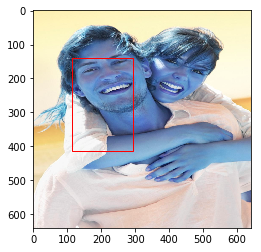

In [29]:
show_anchor(image_resized, final )